# Redundant features from all the observations

In [5]:
import pandas as pd
import re
from collections import Counter

# Load the Excel file
file_path = "Features_count_ADC.xlsx"  # Replace with your actual file path
xls = pd.ExcelFile(file_path)

# Load the sheet into a DataFrame
df = pd.read_excel(xls, sheet_name='Sheet1')  # Adjust sheet name if needed

# Extract the column with important features, dropping NaN values
important_features_column = df['Important Features from Experiment'].dropna()

# List to store extracted features from all experiments
all_features = []

# Extract feature names using regex
for entry in important_features_column:
    features = re.findall(r'(\w+):', entry)
    all_features.extend(features)

# Count occurrences of each feature
feature_counts = Counter(all_features)

# Convert to DataFrame
feature_counts_df = pd.DataFrame(feature_counts.items(), columns=['Feature', 'Count'])

# Filter features with occurrences >= 90
filtered_features_df = feature_counts_df[feature_counts_df['Count'] >= 90]

# Sort by count in descending order
sorted_filtered_features_df = filtered_features_df.sort_values(by='Count', ascending=False)

# Display the filtered DataFrame
print(sorted_filtered_features_df)


        Feature  Count
2        Mean_H    180
5         RMS_H    180
11       Mean_L    180
18   Variance_L    180
13        RMS_L    180
7   Mean_Freq_H    178
16    Entropy_L    178
0         Max_H    176
6     Entropy_H    176
4   Deviation_H    172
10        Min_L    170
8    Variance_H    156
17  Mean_Freq_L    135
1         Min_H    114
25  Deviation_L    104
9         Max_L     95
12        Std_L     90


# PCA Scree Plot (38 features vs 19 features)

✅ Loaded file: C:\Users\awm21\Documents\Probe_Vari\Neural_Networks\Features_Vitis\P1_fd\fd_Probe1_ADC1_CH1_10_MSPS.npy | Shape: (9998, 38)
✅ Loaded file: C:\Users\awm21\Documents\Probe_Vari\Neural_Networks\Features_Vitis\P1_fd\fd_Probe1_ADC1_CH2_10_MSPS.npy | Shape: (9998, 38)


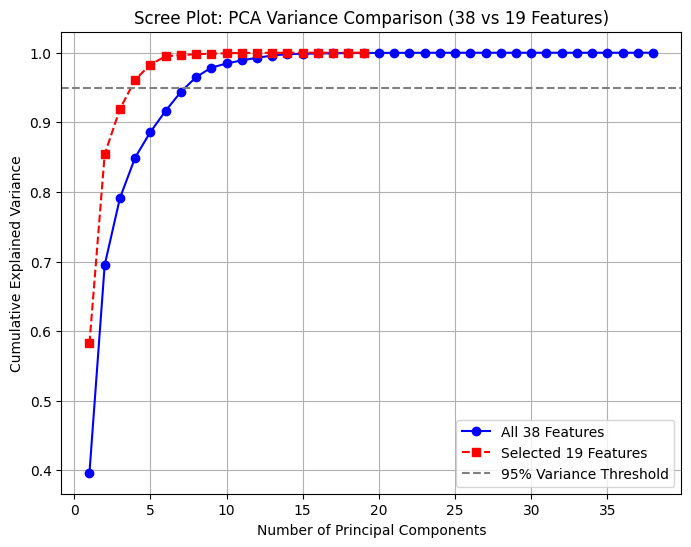

In [9]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ==================================================================
# Configuration (Modify this for your file locations)
# ==================================================================
base_directory = "C:\\Users\\awm21\\Documents\\Probe_Vari\\Neural_Networks\\Features_Vitis\\P1_fd"

adc_num = 1  # Using ADC1
probe_name = "Probe1"
sample_rate = 10

# File paths
file_ch1 = os.path.join(base_directory, f"fd_{probe_name}_ADC{adc_num}_CH1_{sample_rate}_MSPS.npy")
file_ch2 = os.path.join(base_directory, f"fd_{probe_name}_ADC{adc_num}_CH2_{sample_rate}_MSPS.npy")

# ==================================================================
# Load Data Function
# ==================================================================
def load_data(file_path):
    """Load data from the given .npy file."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    data = np.load(file_path)
    print(f"✅ Loaded file: {file_path} | Shape: {data.shape}")
    return data

# ==================================================================
# Load Data from CH1 and CH2
# ==================================================================
data_ch1 = load_data(file_ch1)
data_ch2 = load_data(file_ch2)

# Stack the two datasets together
X_all_features = np.vstack([data_ch1, data_ch2])

# ==================================================================
# Feature Selection (38 Features -> 19 Features)
# ==================================================================
# List of all 38 available features
all_feature_names = [
    "Max_H", "Min_H", "Mean_H", "Std_H", "Mean Deviation_H", "RMS_H", "Skewness_H", "Kurtosis_H", "Peak-to-Peak_H", "Zero Crossing Rate_H",
    "Centroid_H", "Entropy_H", "Spread_H", "Skewness_Freq_H", "Mean_Freq_H", "Kurtosis_Freq_H", "Irregularity_H", "Variance_H", "Dominant_Freq_H",
    "Max_L", "Min_L", "Mean_L", "Std_L", "Mean Deviation_L", "RMS_L", "Skewness_L", "Kurtosis_L", "Peak-to-Peak_L", "Zero Crossing Rate_L",
    "Centroid_L", "Entropy_L", "Spread_L", "Skewness_Freq_L", "Mean_Freq_L", "Kurtosis_Freq_L", "Irregularity_L", "Variance_L", "Dominant_Freq_L"
]

# Select only the 19 most important features
selected_features = [
    "Mean_H", "RMS_H", "Mean_L", "Variance_L", "RMS_L", "Mean_Freq_H", "Entropy_L", 
    "Max_H", "Entropy_H", "Mean Deviation_H", "Min_L", "Variance_H", "Mean_Freq_L", 
    "Min_H", "Mean Deviation_L", "Max_L", "Std_L", "Skewness_H", "Skewness_L"
]

# Get indices of selected features in the original dataset
selected_feature_indices = [all_feature_names.index(f) for f in selected_features]

# Select only the 19 required features from the dataset
X_selected_features = X_all_features[:, selected_feature_indices]

# ==================================================================
# Standardization (Scaling)
# ==================================================================
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all_features)
X_selected_scaled = scaler.fit_transform(X_selected_features)

# ==================================================================
# Perform PCA for 38 Features and 19 Features
# ==================================================================
pca_all = PCA(n_components=38)
pca_all.fit(X_all_scaled)

pca_selected = PCA(n_components=19)
pca_selected.fit(X_selected_scaled)

# Get explained variance ratio
explained_variance_all = np.cumsum(pca_all.explained_variance_ratio_)
explained_variance_selected = np.cumsum(pca_selected.explained_variance_ratio_)

# ==================================================================
# Plot Scree Plot (Explained Variance)
# ==================================================================
plt.figure(figsize=(8, 6))
plt.plot(range(1, 39), explained_variance_all, marker='o', linestyle='-', color='blue', label='All 38 Features')
plt.plot(range(1, 20), explained_variance_selected, marker='s', linestyle='--', color='red', label='Selected 19 Features')

plt.axhline(y=0.95, color='gray', linestyle='dashed', label='95% Variance Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot: PCA Variance Comparison (38 vs 19 Features)')
plt.legend()
plt.grid(True)

plt.show()


# PCA Representation of Selected 19 Features (CH1 vs CH2, High vs Low)

✅ Loaded file: C:\Users\awm21\Documents\Probe_Vari\Neural_Networks\Features_Vitis\P1_fd\fd_Probe1_ADC1_CH1_30_MSPS.npy | Shape: (3332, 38)
✅ Loaded file: C:\Users\awm21\Documents\Probe_Vari\Neural_Networks\Features_Vitis\P1_fd\fd_Probe1_ADC1_CH2_30_MSPS.npy | Shape: (3332, 38)


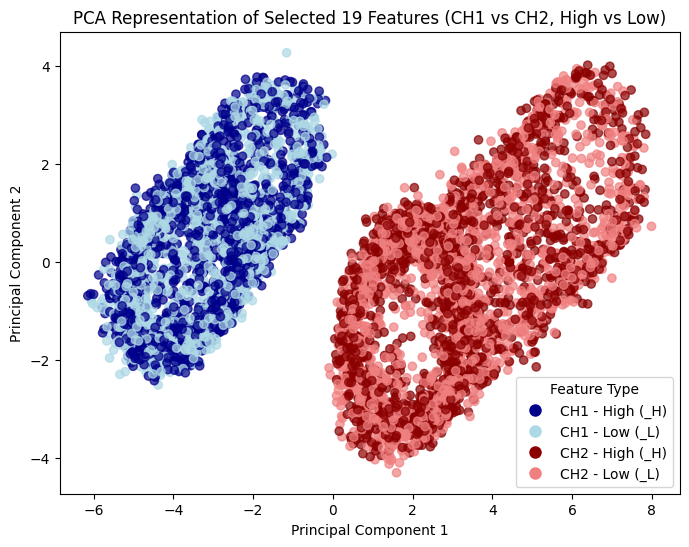

In [ ]:
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ==================================================================
# Configuration
# ==================================================================
base_directory = "C:\\Users\\awm21\\Documents\\Probe_Vari\\Neural_Networks\\Features_Vitis\\P1_fd"

adc_num = 1  # Using ADC1
probe_name = "Probe1"
sample_rate = 30

# File paths
file_ch1 = os.path.join(base_directory, f"fd_{probe_name}_ADC{adc_num}_CH1_{sample_rate}_MSPS.npy")
file_ch2 = os.path.join(base_directory, f"fd_{probe_name}_ADC{adc_num}_CH2_{sample_rate}_MSPS.npy")

# List of all 38 available features
all_feature_names = [
    "Max_H", "Min_H", "Mean_H", "Std_H", "Mean Deviation_H", "RMS_H", "Skewness_H", "Kurtosis_H", "Peak-to-Peak_H", "Zero Crossing Rate_H",
    "Centroid_H", "Entropy_H", "Spread_H", "Skewness_Freq_H", "Mean_Freq_H", "Kurtosis_Freq_H", "Irregularity_H", "Variance_H", "Dominant_Freq_H",
    "Max_L", "Min_L", "Mean_L", "Std_L", "Mean Deviation_L", "RMS_L", "Skewness_L", "Kurtosis_L", "Peak-to-Peak_L", "Zero Crossing Rate_L",
    "Centroid_L", "Entropy_L", "Spread_L", "Skewness_Freq_L", "Mean_Freq_L", "Kurtosis_Freq_L", "Irregularity_L", "Variance_L", "Dominant_Freq_L"
]

# Select only the 19 required features from the 38 available
selected_features = [
    "Mean_H", "RMS_H", "Mean_L", "Variance_L", "RMS_L", "Mean_Freq_H", "Entropy_L", 
    "Max_H", "Entropy_H", "Mean Deviation_H", "Min_L", "Variance_H", "Mean_Freq_L", 
    "Min_H", "Mean Deviation_L", "Max_L", "Std_L", "Skewness_H", "Skewness_L"
]

# Get indices of selected features in the original dataset
selected_feature_indices = [all_feature_names.index(f) for f in selected_features]

def load_data(file_path):
    """Load data from the given .npy file."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    data = np.load(file_path)
    print(f"✅ Loaded file: {file_path} | Shape: {data.shape}")
    return data

# ==================================================================
# Load the Two Files
# ==================================================================
data_ch1 = load_data(file_ch1)
data_ch2 = load_data(file_ch2)

# Select only the 19 required features from each dataset
X_ch1_selected = data_ch1[:, selected_feature_indices]
X_ch2_selected = data_ch2[:, selected_feature_indices]

# Stack the two datasets together
X_data = np.vstack([X_ch1_selected, X_ch2_selected])

# Create labels: 0 for CH1, 1 for CH2
y_labels = np.concatenate([np.zeros(X_ch1_selected.shape[0]), np.ones(X_ch2_selected.shape[0])])

# Standardize the selected features
scaler = StandardScaler()
X_data_scaled = scaler.fit_transform(X_data)

# ==================================================================
# Perform PCA for Visualization
# ==================================================================
pca = PCA(n_components=2)  # Reduce to 2D for visualization
X_pca = pca.fit_transform(X_data_scaled)

# Generate colors for each sample
colors = []
for i in range(len(y_labels)):  # Iterate over each data sample
    if y_labels[i] == 0:  # CH1
        colors.append("darkblue" if i % 2 == 0 else "lightblue")  # Alternate _H and _L colors
    else:  # CH2
        colors.append("darkred" if i % 2 == 0 else "lightcoral")  # Alternate _H and _L colors

# Plot PCA representation with distinct colors for _H and _L features of CH1 & CH2
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.7)

# Create a custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='darkblue', markersize=10, label='CH1 - High (_H)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='CH1 - Low (_L)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='darkred', markersize=10, label='CH2 - High (_H)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=10, label='CH2 - Low (_L)'),
]
plt.legend(handles=legend_elements, title="Feature Type", loc="best")

plt.title("PCA Representation of Selected 19 Features (CH1 vs CH2, High vs Low)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


# PCA Representation at different sampling rates

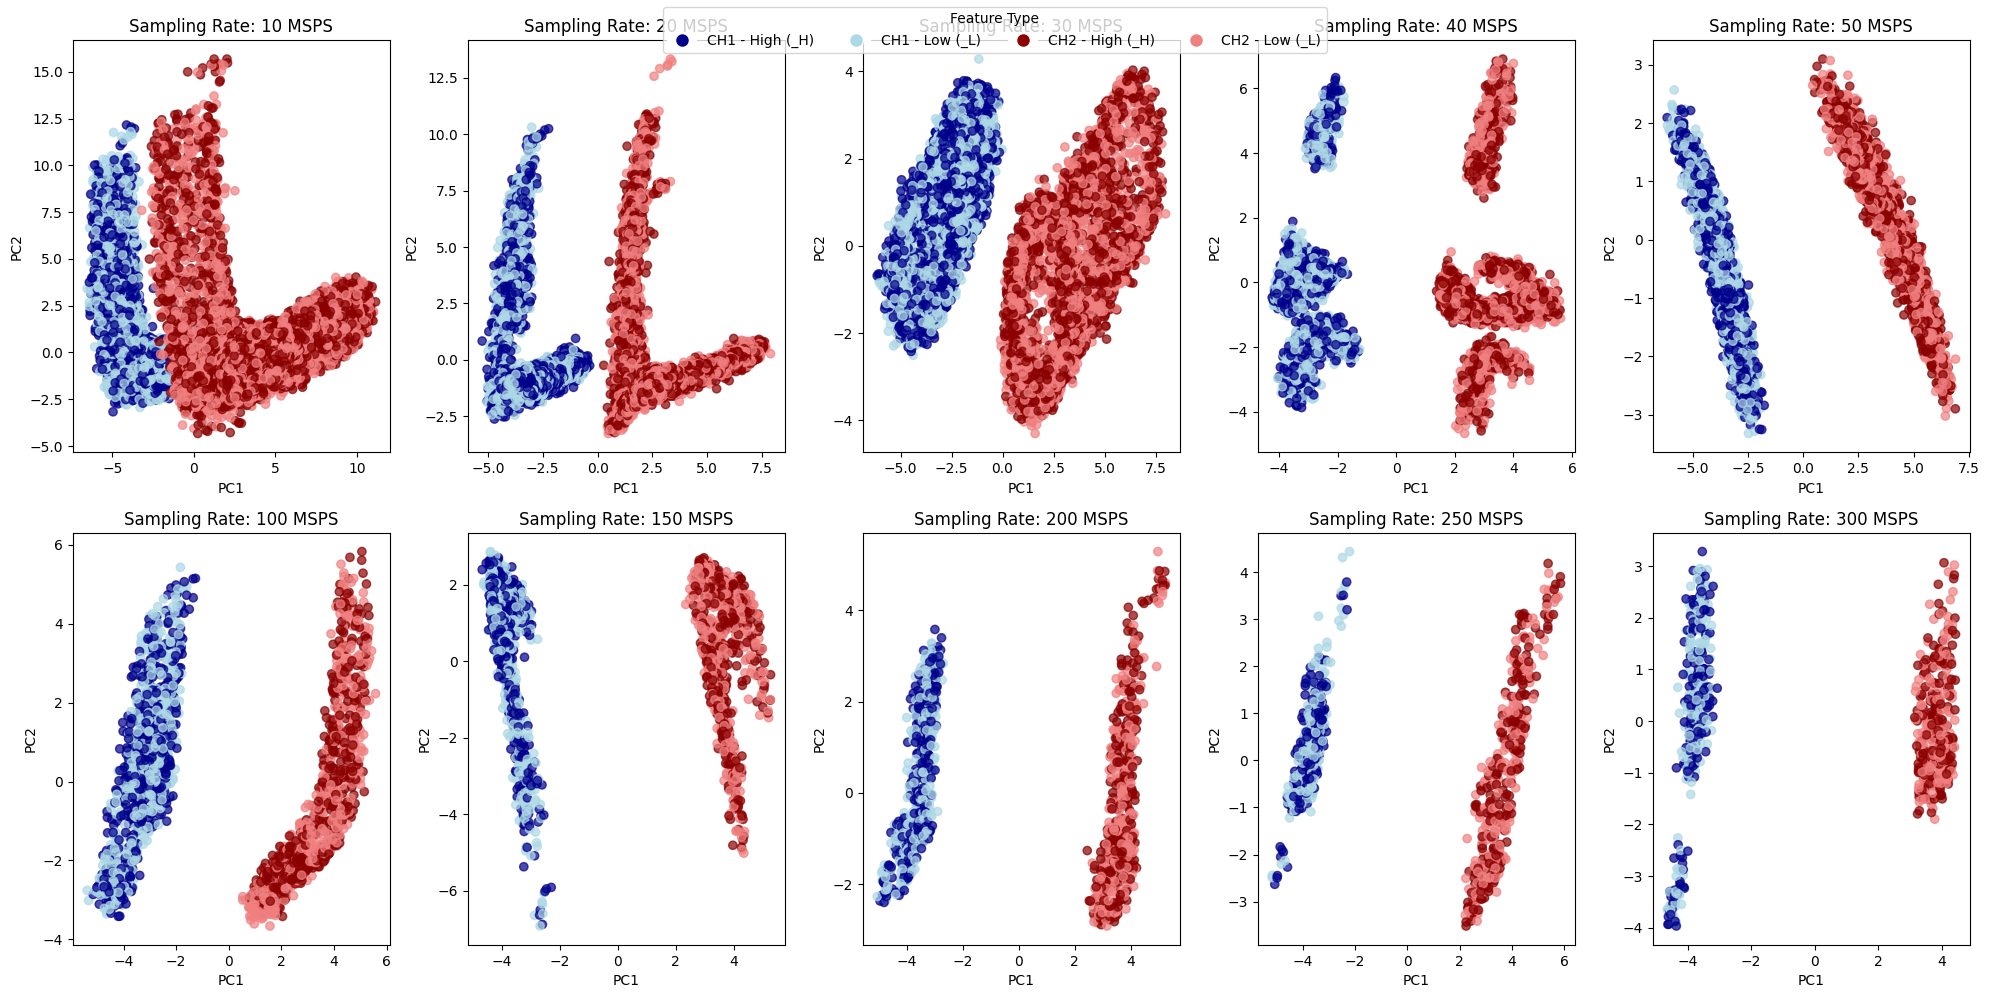

In [3]:
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D

# ==================================================================
# Configuration
# ==================================================================
base_directory = "C:\\Users\\awm21\\Documents\\Probe_Vari\\Neural_Networks\\Features_Vitis\\P1_fd"

adc_num = 1  # Using ADC1
probe_name = "Probe1"
sampling_rates = [10, 20, 30, 40, 50, 100, 150, 200, 250, 300]  # Multiple sampling rates

# List of all 38 available features
all_feature_names = [
    "Max_H", "Min_H", "Mean_H", "Std_H", "Mean Deviation_H", "RMS_H", "Skewness_H", "Kurtosis_H", "Peak-to-Peak_H", "Zero Crossing Rate_H",
    "Centroid_H", "Entropy_H", "Spread_H", "Skewness_Freq_H", "Mean_Freq_H", "Kurtosis_Freq_H", "Irregularity_H", "Variance_H", "Dominant_Freq_H",
    "Max_L", "Min_L", "Mean_L", "Std_L", "Mean Deviation_L", "RMS_L", "Skewness_L", "Kurtosis_L", "Peak-to-Peak_L", "Zero Crossing Rate_L",
    "Centroid_L", "Entropy_L", "Spread_L", "Skewness_Freq_L", "Mean_Freq_L", "Kurtosis_Freq_L", "Irregularity_L", "Variance_L"
]

# Select only the 19 required features from the 38 available
selected_features = [
    "Mean_H", "RMS_H", "Mean_L", "Variance_L", "RMS_L", "Mean_Freq_H", "Entropy_L", 
    "Max_H", "Entropy_H", "Mean Deviation_H", "Min_L", "Variance_H", "Mean_Freq_L", 
    "Min_H", "Mean Deviation_L", "Max_L", "Std_L", "Skewness_H", "Skewness_L"
]

# Get indices of selected features in the original dataset
selected_feature_indices = [all_feature_names.index(f) for f in selected_features]

def load_data(file_path):
    """Load data from the given .npy file."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    data = np.load(file_path)
    return data

# ==================================================================
# Plot PCA for Each Sampling Rate
# ==================================================================
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # Create 2x5 grid of subplots

for idx, sample_rate in enumerate(sampling_rates):
    row, col = divmod(idx, 5)  # Get row and column index for subplot

    # File paths for CH1 and CH2
    file_ch1 = os.path.join(base_directory, f"fd_{probe_name}_ADC{adc_num}_CH1_{sample_rate}_MSPS.npy")
    file_ch2 = os.path.join(base_directory, f"fd_{probe_name}_ADC{adc_num}_CH2_{sample_rate}_MSPS.npy")

    # Load the Two Files
    try:
        data_ch1 = load_data(file_ch1)
        data_ch2 = load_data(file_ch2)
    except FileNotFoundError:
        print(f"Skipping sampling rate {sample_rate}, file not found.")
        continue

    # Select only the 19 required features from each dataset
    X_ch1_selected = data_ch1[:, selected_feature_indices]
    X_ch2_selected = data_ch2[:, selected_feature_indices]

    # Stack the two datasets together
    X_data = np.vstack([X_ch1_selected, X_ch2_selected])

    # Create labels: 0 for CH1, 1 for CH2
    y_labels = np.concatenate([np.zeros(X_ch1_selected.shape[0]), np.ones(X_ch2_selected.shape[0])])

    # Standardize the selected features
    scaler = StandardScaler()
    X_data_scaled = scaler.fit_transform(X_data)

    # Perform PCA for Visualization
    pca = PCA(n_components=2)  # Reduce to 2D for visualization
    X_pca = pca.fit_transform(X_data_scaled)

    # Generate colors for each sample
    colors = []
    for i in range(len(y_labels)):  # Iterate over each data sample
        if y_labels[i] == 0:  # CH1
            colors.append("darkblue" if i % 2 == 0 else "lightblue")  # Alternate _H and _L colors
        else:  # CH2
            colors.append("darkred" if i % 2 == 0 else "lightcoral")  # Alternate _H and _L colors

    # Plot PCA representation with distinct colors for _H and _L features of CH1 & CH2
    axes[row, col].scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.7)
    axes[row, col].set_title(f"Sampling Rate: {sample_rate} MSPS")
    axes[row, col].set_xlabel("PC1")
    axes[row, col].set_ylabel("PC2")

# Create a custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='darkblue', markersize=10, label='CH1 - High (_H)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='CH1 - Low (_L)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='darkred', markersize=10, label='CH2 - High (_H)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=10, label='CH2 - Low (_L)'),
]
fig.legend(handles=legend_elements, title="Feature Type", loc="upper center", ncol=4)

plt.tight_layout()
plt.show()



# Experiment Model Training using 19 features

In [1]:
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, matthews_corrcoef, 
    balanced_accuracy_score, log_loss, f1_score, recall_score, precision_score
)

# ==================================================================
# Fixed Configuration
# ==================================================================
base_directory = "C:\\Users\\awm21\\Documents\\Probe_Vari\\Neural_Networks\\Features_Vitis"

adc_num = 3
train_probe_dataset = 1
test_probe_dataset = 2
sample_rate = 50

train_probe = f"Probe{train_probe_dataset}"
test_probe = f"Probe{test_probe_dataset}"

# List of all 38 loaded features
all_feature_names = [
    "Max_H", "Min_H", "Mean_H", "Std_H", "Mean Deviation_H", "RMS_H", "Skewness_H", "Kurtosis_H", "Peak-to-Peak_H", "Zero Crossing Rate_H",
    "Centroid_H", "Entropy_H", "Spread_H", "Skewness_Freq_H", "Mean_Freq_H", "Kurtosis_Freq_H", "Irregularity_H", "Variance_H", "Dominant_Freq_H",
    "Max_L", "Min_L", "Mean_L", "Std_L", "Mean Deviation_L", "RMS_L", "Skewness_L", "Kurtosis_L", "Peak-to-Peak_L", "Zero Crossing Rate_L",
    "Centroid_L", "Entropy_L", "Spread_L", "Skewness_Freq_L", "Mean_Freq_L", "Kurtosis_Freq_L", "Irregularity_L", "Variance_L"
]

# Select only the 19 required features from the 38 loaded features
selected_features = [
    "Mean_H", "RMS_H", "Mean_L", "Variance_L", "RMS_L", "Mean_Freq_H", "Entropy_L", 
    "Max_H", "Entropy_H", "Mean Deviation_H", "Min_L", "Variance_H", "Mean_Freq_L", 
    "Min_H", "Mean Deviation_L", "Max_L", "Std_L", "Skewness_H", "Skewness_L"
]

# Get indices of selected features in the original dataset
selected_feature_indices = [all_feature_names.index(f) for f in selected_features]

def load_channel_data(probe_name, adc_num, channel):
    """Load specific ADC/channel data for a probe and verify ADC consistency."""
    folder = os.path.join(base_directory, f"P{probe_name[-1]}_fd")
    filename = f'fd_{probe_name}_ADC{adc_num}_CH{channel}_{sample_rate}_MSPS.npy'
    file_path = os.path.join(folder, filename)
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    data = np.load(file_path)
    print(f"✅ Loaded {probe_name} ADC{adc_num} CH{channel}: {data.shape}")
    return data

# ==================================================================
# Training & Test Data
# ==================================================================
train_ch0 = load_channel_data(train_probe, adc_num, 1)
train_ch1 = load_channel_data(train_probe, adc_num, 2)
test_ch0 = load_channel_data(test_probe, adc_num, 1)
test_ch1 = load_channel_data(test_probe, adc_num, 2)

# Stack training and test data
X_train = np.vstack([train_ch0, train_ch1])
y_train = np.concatenate([np.zeros(train_ch0.shape[0]), np.ones(train_ch1.shape[0])])
X_test = np.vstack([test_ch0, test_ch1])
y_test = np.concatenate([np.zeros(test_ch0.shape[0]), np.ones(test_ch1.shape[0])])

# ==================================================================
# Data Preprocessing
# ==================================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Select only required 19 features from the 38 loaded dataset
X_train_selected = X_train_scaled[:, selected_feature_indices]
X_test_selected = X_test_scaled[:, selected_feature_indices]

# ==================================================================
# Train Model with Selected Features (19 Features)
# ==================================================================
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)
rf.fit(X_train_selected, y_train)

# Get feature importance only for selected features
feature_importances = rf.feature_importances_

# Print Selected Features and their Importances
print("\nSelected Features and Importances:")
for feature_idx, feature_name in zip(range(len(selected_features)), selected_features):
    print(f"{feature_name}: Importance {feature_importances[feature_idx]:.4f}")

# ==================================================================
# Retrain Model with Selected Features
# ==================================================================
rf_selected = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)
rf_selected.fit(X_train_selected, y_train)

# Create a unique folder name dynamically
model_dir = f"Models/19_Feature_Tuning_{train_probe}_to_{test_probe}_ADC{adc_num}_{sample_rate}_MSPS"
os.makedirs(model_dir, exist_ok=True)

# Save the Model and Scaler
joblib.dump(rf_selected, os.path.join(model_dir, "RandomForest_Model.pkl"))
joblib.dump(scaler, os.path.join(model_dir, "Scaler.pkl"))
joblib.dump(selected_feature_indices, os.path.join(model_dir, "Selected_Features.pkl"))

# Predictions
y_pred_selected = rf_selected.predict(X_test_selected)
y_probs_selected = rf_selected.predict_proba(X_test_selected)[:, 1]

# ==================================================================
# Performance Metrics After Feature Selection
# ==================================================================
print("\nModel Performance Using 19 Features:")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_selected):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_selected):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred_selected):.4f}")
print(f"Log Loss: {log_loss(y_test, y_probs_selected):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_selected):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_selected):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_selected):.4f}")
print(classification_report(y_test, y_pred_selected, target_names=['CH1', 'CH2']))

# Compute Confusion Matrix, FPR, and FNR
cm = confusion_matrix(y_test, y_pred_selected)
print("\nConfusion Matrix:")
print(cm)
fp_rate = cm[0][1] / (cm[0][1] + cm[0][0])
fn_rate = cm[1][0] / (cm[1][0] + cm[1][1])
print(f"False Positive Rate (FPR): {fp_rate:.4f}")
print(f"False Negative Rate (FNR): {fn_rate:.4f}")


✅ Loaded Probe1 ADC3 CH1: (1998, 38)
✅ Loaded Probe1 ADC3 CH2: (1998, 38)
✅ Loaded Probe2 ADC3 CH1: (1998, 38)
✅ Loaded Probe2 ADC3 CH2: (1998, 38)

Selected Features and Importances:
Mean_H: Importance 0.1924
RMS_H: Importance 0.1457
Mean_L: Importance 0.1327
Variance_L: Importance 0.0800
RMS_L: Importance 0.1212
Mean_Freq_H: Importance 0.0242
Entropy_L: Importance 0.0128
Max_H: Importance 0.1014
Entropy_H: Importance 0.0748
Mean Deviation_H: Importance 0.0000
Min_L: Importance 0.0058
Variance_H: Importance 0.1087
Mean_Freq_L: Importance 0.0000
Min_H: Importance 0.0000
Mean Deviation_L: Importance 0.0003
Max_L: Importance 0.0000
Std_L: Importance 0.0002
Skewness_H: Importance 0.0000
Skewness_L: Importance 0.0000

Model Performance Using 19 Features:
Test Accuracy: 1.0000
Balanced Accuracy: 1.0000
MCC: 1.0000
Log Loss: 0.0010
F1 Score: 1.0000
Recall: 1.0000
Precision: 1.0000
              precision    recall  f1-score   support

         CH1       1.00      1.00      1.00      1998
   

# Experiment Testing using 19 features 

In [2]:
import numpy as np
import os
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, log_loss,
    f1_score, recall_score, precision_score, matthews_corrcoef, balanced_accuracy_score
)

# ==================================================================
# Fixed Configuration
# ==================================================================
base_directory = "C:\\Users\\awm21\\Documents\\Probe_Vari\\Neural_Networks\\Features_Vitis"

adc_num = 2
test_probe_dataset = 1
sample_rate = 50

test_probe = f"Probe{test_probe_dataset}"

# Directory where the model and scaler were saved
model_dir = f"Models/19_Feature_Tuning_Probe1_to_Probe2_ADC3_50_MSPS"

# Load the trained model and scaler
model_path = os.path.join(model_dir, "RandomForest_Model.pkl")
scaler_path = os.path.join(model_dir, "Scaler.pkl")
features_path = os.path.join(model_dir, "Selected_Features.pkl")

if not os.path.exists(model_path) or not os.path.exists(scaler_path) or not os.path.exists(features_path):
    raise FileNotFoundError("Model, scaler, or selected features file not found.")

rf_selected = joblib.load(model_path)
scaler = joblib.load(scaler_path)
selected_feature_indices = joblib.load(features_path)

# List of all 38 loaded features
all_feature_names = [
    "Max_H", "Min_H", "Mean_H", "Std_H", "Mean Deviation_H", "RMS_H", "Skewness_H", "Kurtosis_H", "Peak-to-Peak_H", "Zero Crossing Rate_H",
    "Centroid_H", "Entropy_H", "Spread_H", "Skewness_Freq_H", "Mean_Freq_H", "Kurtosis_Freq_H", "Irregularity_H", "Variance_H", "Dominant_Freq_H",
    "Max_L", "Min_L", "Mean_L", "Std_L", "Mean Deviation_L", "RMS_L", "Skewness_L", "Kurtosis_L", "Peak-to-Peak_L", "Zero Crossing Rate_L",
    "Centroid_L", "Entropy_L", "Spread_L", "Skewness_Freq_L", "Mean_Freq_L", "Kurtosis_Freq_L", "Irregularity_L", "Variance_L"
]

# Get feature names for selected features
selected_features = [all_feature_names[i] for i in selected_feature_indices]

def load_channel_data(probe_name, adc_num, channel):
    """Load specific ADC/channel data for a probe and verify ADC consistency."""
    folder = os.path.join(base_directory, f"P{probe_name[-1]}_fd")
    filename = f'fd_{probe_name}_ADC{adc_num}_CH{channel}_{sample_rate}_MSPS.npy'
    file_path = os.path.join(folder, filename)
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    data = np.load(file_path)
    print(f"✅ Loaded {probe_name} ADC{adc_num} CH{channel}: {data.shape}")
    return data

# ==================================================================
# Load Test Data
# ==================================================================
test_ch0 = load_channel_data(test_probe, adc_num, 1)
test_ch1 = load_channel_data(test_probe, adc_num, 2)

# Stack test data
X_test = np.vstack([test_ch0, test_ch1])
y_test = np.concatenate([np.zeros(test_ch0.shape[0]), np.ones(test_ch1.shape[0])])

# Apply standardization using the loaded scaler
X_test_scaled = scaler.transform(X_test)

# Select only required 19 features from the 38 loaded dataset
X_test_selected = X_test_scaled[:, selected_feature_indices]

# ==================================================================
# Evaluate the Model
# ==================================================================
y_pred_selected = rf_selected.predict(X_test_selected)
y_probs_selected = rf_selected.predict_proba(X_test_selected)[:, 1]

# Print Model Performance
print("\nModel Performance Using 19 Features:")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_selected):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_selected):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred_selected):.4f}")
print(f"Log Loss: {log_loss(y_test, y_probs_selected):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_selected):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_selected):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_selected):.4f}")
print(classification_report(y_test, y_pred_selected, target_names=['CH1', 'CH2']))

# Compute Confusion Matrix, FPR, and FNR
cm = confusion_matrix(y_test, y_pred_selected)
print("\nConfusion Matrix:")
print(cm)
fp_rate = cm[0][1] / (cm[0][1] + cm[0][0])
fn_rate = cm[1][0] / (cm[1][0] + cm[1][1])
print(f"False Positive Rate (FPR): {fp_rate:.4f}")
print(f"False Negative Rate (FNR): {fn_rate:.4f}")


✅ Loaded Probe1 ADC2 CH1: (1998, 38)
✅ Loaded Probe1 ADC2 CH2: (1998, 38)

Model Performance Using 19 Features:
Test Accuracy: 1.0000
Balanced Accuracy: 1.0000
MCC: 1.0000
Log Loss: 0.0031
F1 Score: 1.0000
Recall: 1.0000
Precision: 1.0000
              precision    recall  f1-score   support

         CH1       1.00      1.00      1.00      1998
         CH2       1.00      1.00      1.00      1998

    accuracy                           1.00      3996
   macro avg       1.00      1.00      1.00      3996
weighted avg       1.00      1.00      1.00      3996


Confusion Matrix:
[[1998    0]
 [   0 1998]]
False Positive Rate (FPR): 0.0000
False Negative Rate (FNR): 0.0000
